# Time Series Forecasting with Transformer

This notebook explores time series forecasting using TensorFlow.
Time series forecasting involves predicting future values based on past observations. In this project, we will:

1. **Generate Synthetic Time Series Data:**
   Create synthetic time series data with multiple components, including sine waves and random noise. This data will be used for training and validation.

2. **Build and Train a Sequence Model:**
   Define a sequence-to-one model using Transformer model. Train the model on the synthetic time series data to learn patterns and relationships.

3. **Evaluate Model Performance:**
   Evaluate the trained model on a validation set to assess its ability to generalize to unseen data. Visualize the original and predicted time series to understand the model's performance.

4. **Make Future Predictions:**
   Implement a function, `predict_future`, to generate predictions for future steps beyond the training data. This function uses the trained model to iteratively forecast future values.

5. **Visualize Future Predictions:**
   Use the `predict_future` function to generate and visualize predictions for future steps. This helps assess the model's ability to capture patterns in unseen data.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(0)
np.random.seed(0)

In [2]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(6, 4))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Creating synthetic Data

In [3]:
time = np.arange(0, 400, 0.1)
series = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))

## Splitting the data

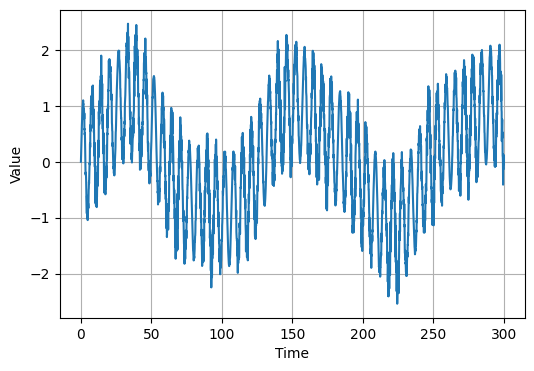

In [4]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time_train, x_train, xlabel='Time', ylabel='Value')

## Creating Windowed Dataset

In [5]:
def windowed_dataset(series, window_size, batch_size, train = True):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (tf.expand_dims(window[:-1], axis = -1), tf.expand_dims(window[-1], axis = -1)))

    if train:
      # Shuffle the windows
      dataset = dataset.shuffle(1000)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [6]:
# Parameters
window_size = 30
batch_size = 32

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size)
val_set = windowed_dataset(x_valid, window_size, batch_size, train = False)

## Creating the Model

Here we will build the transformer layers from scratch (Encoder and Decoder) then combining them to build the transformer.

In [7]:
class PositionalEncoding(tf.keras.layers.Layer):
    """
    Positional Encoding layer for adding positional information to input sequences.

    Parameters:
    - d_model (int): Dimensionality of the model.
    - max_len (int, optional): Maximum length of input sequences. Default is 5000.

    Attributes:
    - pe (tf.Tensor): Positional encoding matrix.

    Methods:
    - call(x): Adds positional encoding to input sequences.
    """

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding matrix
        position = np.arange(0, max_len, dtype=np.float32)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2, dtype=np.float32) * -(np.log(10000.0) / d_model))
        pe = np.zeros((max_len, d_model), dtype=np.float32)
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, :, :]

        # Convert to TensorFlow constant
        self.pe = tf.constant(pe)

    def call(self, x):
        """
        Adds positional encoding to input sequences.

        Parameters:
        - x (tf.Tensor): Input sequence.

        Returns:
        - tf.Tensor: Sequence with positional encoding added.
        """
        return x + self.pe[:, tf.shape(x)[1], :]

In [8]:
class SelfAttention(tf.keras.layers.Layer):
    """
    Self-Attention layer using Multi-Head Attention mechanism.

    Parameters:
    - **kwargs: Additional keyword arguments passed to MultiHeadAttention.

    Attributes:
    - mha (tf.keras.layers.MultiHeadAttention): MultiHeadAttention layer.
    - layernorm (tf.keras.layers.LayerNormalization): LayerNormalization layer.
    - add (tf.keras.layers.Add): Additive layer.

    Methods:
    - call(x): Forward pass through the self-attention layer.
    """

    def __init__(self, **kwargs):
        super().__init__()

        # Multi-Head Attention layer
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)

        # Layer Normalization layer
        self.layernorm = tf.keras.layers.LayerNormalization(axis=-1)

        # Additive layer
        self.add = tf.keras.layers.Add()

    def call(self, x):
        """
        Forward pass through the self-attention layer.

        Parameters:
        - x (tf.Tensor): Input sequence.

        Returns:
        - tf.Tensor: Output sequence after self-attention processing.
        """
        # Multi-Head Attention
        attn_output = self.mha(query=x, key=x, value=x, use_causal_mask=True)

        # Add residual connection
        x = self.add([x, attn_output])

        # Layer Normalization
        x = self.layernorm(x)

        return x


In [9]:
class FeedForward(tf.keras.layers.Layer):
    """
    FeedForward layer with dense hidden layers and dropout.

    Parameters:
    - d_model (int): Dimensionality of the model.
    - dff (int): Number of units in the dense hidden layer.
    - dropout_rate (float, optional): Dropout rate. Default is 0.1.

    Attributes:
    - seq (tf.keras.Sequential): Sequential model for the feedforward network.
    - add (tf.keras.layers.Add): Additive layer.
    - layer_norm (tf.keras.layers.LayerNormalization): LayerNormalization layer.

    Methods:
    - call(x): Forward pass through the feedforward layer.
    """

    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()

        # Sequential model for the feedforward network
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])

        # Additive layer
        self.add = tf.keras.layers.Add()

        # LayerNormalization layer
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        """
        Forward pass through the feedforward layer.

        Parameters:
        - x (tf.Tensor): Input sequence.

        Returns:
        - tf.Tensor: Output sequence after feedforward processing.
        """
        # Apply feedforward network
        x = self.add([x, self.seq(x)])

        # Apply layer normalization
        x = self.layer_norm(x)

        return x

In [10]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder layer in a transformer model consisting of self-attention and feedforward sub-layers.

    Parameters:
    - num_heads (int): Number of attention heads in the self-attention layer.
    - d_model (int): Dimensionality of the model.
    - dff (int): Number of units in the dense hidden layer of the feedforward network.
    - dropout_rate (float, optional): Dropout rate. Default is 0.1.

    Attributes:
    - self_attention (SelfAttention): SelfAttention layer.
    - ffn (FeedForward): FeedForward layer.

    Methods:
    - call(x): Forward pass through the encoder layer.
    """

    def __init__(self, *, num_heads, d_model, dff, dropout_rate=0.1):
        super().__init__()

        # SelfAttention layer
        self.self_attention = SelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

        # FeedForward layer
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        """
        Forward pass through the encoder layer.

        Parameters:
        - x (tf.Tensor): Input sequence.

        Returns:
        - tf.Tensor: Output sequence after encoding.
        """
        # Self-Attention sub-layer
        x = self.self_attention(x)

        # FeedForward sub-layer
        x = self.ffn(x)

        return x

In [11]:
class Encoder(tf.keras.layers.Layer):
    """
    Encoder in a transformer model consisting of multiple encoder layers.

    Parameters:
    - num_layers (int): Number of encoder layers.
    - num_heads (int): Number of attention heads in each encoder layer.
    - d_model (int): Dimensionality of the model.
    - dff (int): Number of units in the dense hidden layer of the feedforward network.
    - dropout_rate (float, optional): Dropout rate. Default is 0.1.

    Attributes:
    - num_layers (int): Number of encoder layers.
    - enc_layers (list): List of EncoderLayer instances.
    - dropout (tf.keras.layers.Dropout): Dropout layer.

    Methods:
    - call(x): Forward pass through the encoder.
    """

    def __init__(self, *, num_layers, num_heads, d_model, dff, dropout_rate=0.1):
        super().__init__()

        # Number of encoder layers
        self.num_layers = num_layers

        # List of EncoderLayer instances
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]

        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        """
        Forward pass through the encoder.

        Parameters:
        - x (tf.Tensor): Input sequence.

        Returns:
        - tf.Tensor: Encoded sequence after processing through multiple encoder layers.
        """
        # Apply dropout to the input sequence
        x = self.dropout(x)

        # Forward pass through each encoder layer
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x

In [12]:
class TransAm(tf.keras.Model):
    """
    Transformer-based Time Series Model.

    Parameters:
    - feature_size (int): Dimensionality of the input features.
    - num_layers (int): Number of encoder layers in the transformer.
    - num_heads (int): Number of attention heads in each encoder layer.
    - dff (int): Number of units in the dense hidden layer of the feedforward network.
    - dropout (float): Dropout rate.

    Attributes:
    - pos_encoder (PositionalEncoding): PositionalEncoding layer.
    - transformer_encoder (Encoder): Encoder layer.
    - decoder (tf.keras.layers.Dense): Dense layer for final output.

    Methods:
    - call(src): Forward pass through the transformer model.
    """

    def __init__(self, feature_size=250, num_layers=1, num_heads=10, dff=2048, dropout=0.1):
        super(TransAm, self).__init__()

        # Positional Encoding layer
        self.pos_encoder = PositionalEncoding(feature_size)

        # Transformer Encoder layer
        self.transformer_encoder = Encoder(num_layers=num_layers, d_model=feature_size, num_heads=num_heads, dff=dff)

        # Dense layer for final output
        self.decoder = tf.keras.layers.Dense(1, activation=None, kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1))

    def call(self, src):
        """
        Forward pass through the transformer model.

        Parameters:
        - src (tf.Tensor): Input sequence.

        Returns:
        - tf.Tensor: Model predictions.
        """
        # Apply positional encoding to the input sequence
        src = self.pos_encoder(src)

        # Forward pass through the transformer encoder
        output = self.transformer_encoder(src)

        # Apply the decoder layer for the final output
        output = self.decoder(output)[:, -1, :][..., np.newaxis]

        return output

## Learning Rate Schedulre

 The learning rate scheduler is designed to adjust the learning rate every epoch and allow to choose a learning rate based on stability and low loss.

In [13]:
model = TransAm()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 16s 22ms/step - loss: 0.4889 - lr: 1.0000e-06
Epoch 2/100
93/93 [==============================] - 2s 20ms/step - loss: 0.4221 - lr: 1.1220e-06
Epoch 3/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3716 - lr: 1.2589e-06
Epoch 4/100
93/93 [==============================] - 2s 20ms/step - loss: 0.3511 - lr: 1.4125e-06
Epoch 5/100
93/93 [==============================] - 2s 17ms/step - loss: 0.3079 - lr: 1.5849e-06
Epoch 6/100
93/93 [==============================] - 1s 13ms/step - loss: 0.2195 - lr: 1.7783e-06
Epoch 7/100
93/93 [==============================] - 1s 13ms/step - loss: 0.1700 - lr: 1.9953e-06
Epoch 8/100
93/93 [==============================] - 1s 13ms/step - loss: 0.1504 - lr: 2.2387e-06
Epoch 9/100
93/93 [==============================] - 1s 14ms/step - loss: 0.1376 - lr: 2.5119e-06
Epoch 10/100
93/93 [==============================] - 1s 14ms/step - loss: 0.1267 - lr: 2.8184e-06
Epoch 11/100
93/93

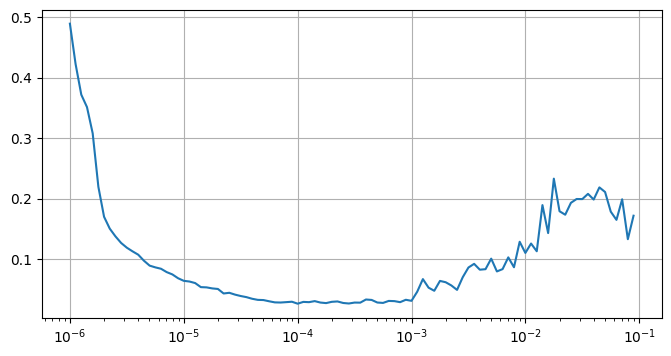

In [14]:
# Define the learning rate array
lrs = 1e-6 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(8, 4))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

plt.show()

In [15]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

## Training the model

Here we train the model with the most appropriate learning rate based on the previous training with learning rate scheduler

In [16]:
model = TransAm()
# Set the learning rate
learning_rate = 1e-4

# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100, validation_data = val_set, callbacks = [early_stopping])

Epoch 1/100
93/93 [==============================] - 7s 35ms/step - loss: 0.1713 - mae: 0.4554 - val_loss: 0.0586 - val_mae: 0.2685
Epoch 2/100
93/93 [==============================] - 2s 16ms/step - loss: 0.0657 - mae: 0.2865 - val_loss: 0.0613 - val_mae: 0.2799
Epoch 3/100
93/93 [==============================] - 2s 16ms/step - loss: 0.0499 - mae: 0.2467 - val_loss: 0.0398 - val_mae: 0.2204
Epoch 4/100
93/93 [==============================] - 2s 17ms/step - loss: 0.0443 - mae: 0.2335 - val_loss: 0.0393 - val_mae: 0.2231
Epoch 5/100
93/93 [==============================] - 2s 17ms/step - loss: 0.0357 - mae: 0.2084 - val_loss: 0.0315 - val_mae: 0.1922
Epoch 6/100
93/93 [==============================] - 2s 17ms/step - loss: 0.0316 - mae: 0.1956 - val_loss: 0.0235 - val_mae: 0.1627
Epoch 7/100
93/93 [==============================] - 2s 23ms/step - loss: 0.0285 - mae: 0.1853 - val_loss: 0.0323 - val_mae: 0.2011
Epoch 8/100
93/93 [==============================] - 2s 17ms/step - loss: 0.

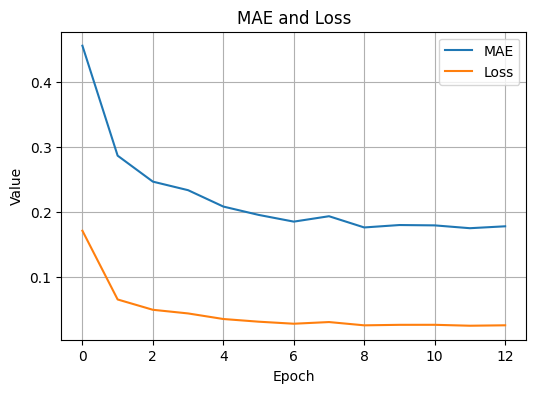

In [17]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(x=epochs, y=(mae, loss), title='MAE and Loss', xlabel='Epoch', ylabel='Value', legend=['MAE', 'Loss'])

In [18]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    dataset = dataset.map(lambda window: tf.expand_dims(window, axis = -1))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose = 0)

    return forecast

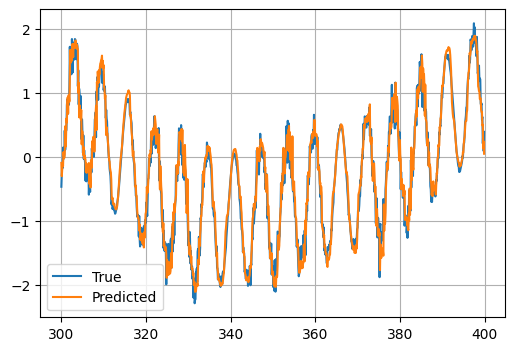

In [19]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results), legend = ["True", "Predicted"])

In [20]:
# Compute the MAE and MSE on the validation set
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

0.15824603
0.043959115


This function takes a trained TensorFlow model, a time series dataset, window size, and the number of steps to predict.
It initializes the input data with the initial portion of the series and iteratively predicts future values using the model.
The resulting tensor contains both the historical and predicted values.

In [21]:
def predict_future(model, series, window_size, steps):
    """
    Generate future predictions using the given model and time series data.

    Parameters:
    - model (tf.keras.Model): Trained model for making predictions.
    - series (numpy.ndarray): Time series data.
    - window_size (int): Size of the input window for making predictions.
    - steps (int): Number of steps to predict into the future.

    Returns:
    - tf.Tensor: Tensor containing the predicted future values.
    """

    # Convert the initial window of the series to a TensorFlow tensor
    data = tf.convert_to_tensor(series[:window_size])

    # Reshape the tensor to match the model input shape
    data = tf.reshape(data, (1, -1, 1))

    # Generate predictions for the specified number of steps into the future
    for i in range(steps):
        forecast = model.predict(data[:, -window_size:, :], verbose=0)
        data = tf.concat((data, forecast), 1)

    return data

In [22]:
# steps = 100
# prediction = predict_future(model, forecast_series, window_size, steps)

In [ ]:
# plot_series(range(window_size + steps), (forecast_series[:window_size + steps], prediction.numpy().squeeze()), legend = ["True", "Predicted"])